For debugging FA Model fitting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from itertools import chain
from pathlib import Path
import pickle

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.matrix_visualization import cmp_n_mats


from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.data_processing import generate_torch_dataset
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.data_processing import SegmentTable
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_basic_posteriors
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import GNLDRMdl
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection

In [3]:
%matplotlib notebook

## Parameters go here

In [17]:
ps = dict()

# Folder with the datasets in it
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Folder with the segment table in it
ps['segment_table_dir'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data'

# File with the segment table in it
ps['segment_table_file'] = r'phototaxis_ns_subjects_1_2_5_6_8_9_10_11.pkl'

# Folder with the fold structure in it
ps['fold_str_dir'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data'

# Give the name of the file with the fold structure in it
ps['fold_str_file'] = 'fold_str_base_14_tgt_1.pkl'

# Specify which fold we are fitting
ps['fold'] = 0

# Specify which subjects we fit - if subject_filter is None, we fit all subjects in the fold structure
ps['subject_filter'] = None

# Gains we apply to neural signals and behavioral variables
ps['neural_gain'] = 10

# Ratio of z-plane spacing to voxel side length in x-y dimensions.
ps['z_ratio'] = 2.5

# Number of latent variables in the model
ps['n_latent_vars'] = 10

# Options for setting up hypercube functions
ps['hc_opts'] = {'n_divisions_per_dim': [50, 30, 17], 
                 'dim_ranges': np.asarray([[0, 990.0], [0, 610.0], [0, 350.0]]),
                 'n_div_per_hc_side_per_dim': [1, 1, 1]}

# Parameters for the priors on scales
ps['s_mn'] = 1.0
ps['s_std'] = .0001

# True if we should use early stopping
ps['use_early_stopping'] = True

# Location to save sp check points
ps['sp_cp_dir'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/testing/gnldr/debug/sp_cp'

# Location to save ip check points
ps['ip_cp_dir'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/testing/gnldr/debug/ip_cp'

# Specify if we use gpus for fitting
ps['use_gpus'] = True

# Options for fitting sp models

ps['sp_fit_opts'] = [{'n_epochs': 1000, 'milestones': [500], 'update_int': 100, 'init_lr': .1,
                                  'cp_epochs': list(range(0, 1000, 100)) + [999]} for _ in range(1)]

# Options for fitting ip models



## See which devices are available for fitting

In [5]:
if ps['use_gpus']:
    devices, _ = list_torch_devices()
else:
    devices = [torch.device('cpu')]

Found 1 GPUs


## Load and prepare data 

Load fold structures

In [6]:
fold_str_path = Path(ps['fold_str_dir']) / ps['fold_str_file']
with open(fold_str_path, 'rb') as f:
    fold_groups = pickle.load(f)


Load segment tables

In [7]:
segment_table_path = Path(ps['segment_table_dir']) / ps['segment_table_file']

with open(segment_table_path, 'rb') as f:
    segment_file_data = pickle.load(f)
    segment_tables = segment_file_data['segment_tables']
    for s_n in segment_tables.keys():
        segment_tables[s_n] = SegmentTable.from_dict(segment_tables[s_n])


Apply subject filter

In [8]:
if ps['subject_filter'] is not None:
    new_fold_groups = {s_n: fold_groups[s_n] for s_n in ps['subject_filter']}
    fold_groups = new_fold_groups


Load data and do basic preprocessing

In [9]:
subjects = list(fold_groups.keys())
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=ps['data_dir'], subjects=subjects,
                                                             neural_gain=ps['neural_gain'], z_ratio=ps['z_ratio'])


Done loading data for subject subject_1.
Done loading data for subject subject_2.
Done loading data for subject subject_5.
Done loading data for subject subject_6.
Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_10.
Done loading data for subject subject_11.


Form training data 

In [10]:
train_data = dict()

for s_n in subjects:
    subject_train_slices = segment_tables[s_n].find_all(fold_groups[s_n][ps['fold']]['train'])
    train_data[s_n] = generate_torch_dataset(dataset=subject_data[s_n], slices=subject_train_slices,
                                                 ts_keys=['dff'], inc_time_stamps=False)

# Convert training data from TimeSeriesBatch objects to Torch tensors
train_data = {s_n: ts_b.data[0] for s_n, ts_b in train_data.items()}


## Setup everything for fitting sp models

In [26]:
ind_n_vars = [train_data[s_n].shape[1] for s_n in subjects]

In [27]:
sp_m_fit = torch.nn.Identity()

In [28]:
sp_priors = generate_hypercube_prior_collection(n_intermediate_latent_vars=ps['n_latent_vars'],
                                                hc_params = ps['hc_opts'], s_mn=ps['s_mn'] , s_std=ps['s_std'] )
    
sp_posteriors = generate_basic_posteriors(n_obs_vars=ind_n_vars, 
                                          n_smps=[train_data[s_n].shape[0] for s_n in subjects], 
                                          n_latent_vars=ps['n_latent_vars'], 
                                          n_intermediate_latent_vars=ps['n_latent_vars'],
                                          s_opts={'mn_mn': ps['s_mn'], 'mn_std': .00000001, 
                                                  'std_lb': ps['s_std']-.0001, 'std_iv': ps['s_std']})

sp_posteriors = {s_n: sp_posteriors[s_i] for s_i, s_n in enumerate(subjects)}

sp_fit_mdls = {s_n: GNLDRMdl(n_latent_vars=ps['n_latent_vars'], m=sp_m_fit) for s_n in subjects}
                    
                                    
sp_vi_collections = [VICollection(data=train_data[s_n], 
                                  props=subject_neuron_locs[s_n],
                                  mdl = sp_fit_mdls[s_n],
                                  posteriors = sp_posteriors[s_n]) for s_n in subjects]

for vi_coll in sp_vi_collections:
    vi_coll.posteriors.lm_post = sp_priors.lm_prior
    vi_coll.posteriors.mn_post = sp_priors.mn_prior

## Fit sp models

Add check point directories to fitting options

In [29]:
for d_i, d in enumerate(ps['sp_fit_opts']):
    d['cp_save_folder'] = ps['sp_cp_dir']
    d['cp_save_str'] = 'rnd_' + str(d_i) + '_'

In [30]:
sp_fitter = Fitter(vi_collections=sp_vi_collections, priors=sp_priors, devices=devices)
sp_fitter.distribute(distribute_data=True, devices=devices)
sp_logs = [sp_fitter.fit(**opts) for opts in ps['sp_fit_opts']]
sp_fitter.distribute(devices=[torch.device('cpu')])



=========== EPOCH 0 COMPLETE ===========
Obj: 1.73e+11
----------------------------------------
NELL: 2.71e+08, 2.28e+08, 1.82e+08, 2.29e+08, 8.15e+06, 3.67e+06, 2.25e+06, 7.20e+06
Latent KL: 5.89e+02, 7.29e+02, 6.30e+02, 7.51e+02, 3.26e+01, 1.42e+01, 7.05e+00, 2.22e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 2.06e+04, 1.97e+04, 2.28e+04, 2.16e+04, 1.67e+04, 1.84e+04, 1.96e+04, 2.33e+04
S KL: 2.08e+10, 2.06e+10, 2.44e+10, 2.31e+10, 1.73e+10, 1.99e+10, 2.08e+10, 2.54e+10
----------------------------------------
LR: 0.1
Elapsed time (secs): 1.1111400127410889
----------------------------------------
CPU cur memory used (GB): 4.60e+01
GPU_0 cur memory used (GB): 5.01e+00, max memory used (GB): 5.01e+00
Saved check point for epoch 0.

=========== EPOCH 100 COMPLETE ===========
Obj: 4.57e+08
----------------------------------------
NELL: 1.11e+08, 1.15

Saved check point for epoch 900.
Saved check point for epoch 999.


## Examine logs of sp model fitting

<IPython.core.display.Javascript object>


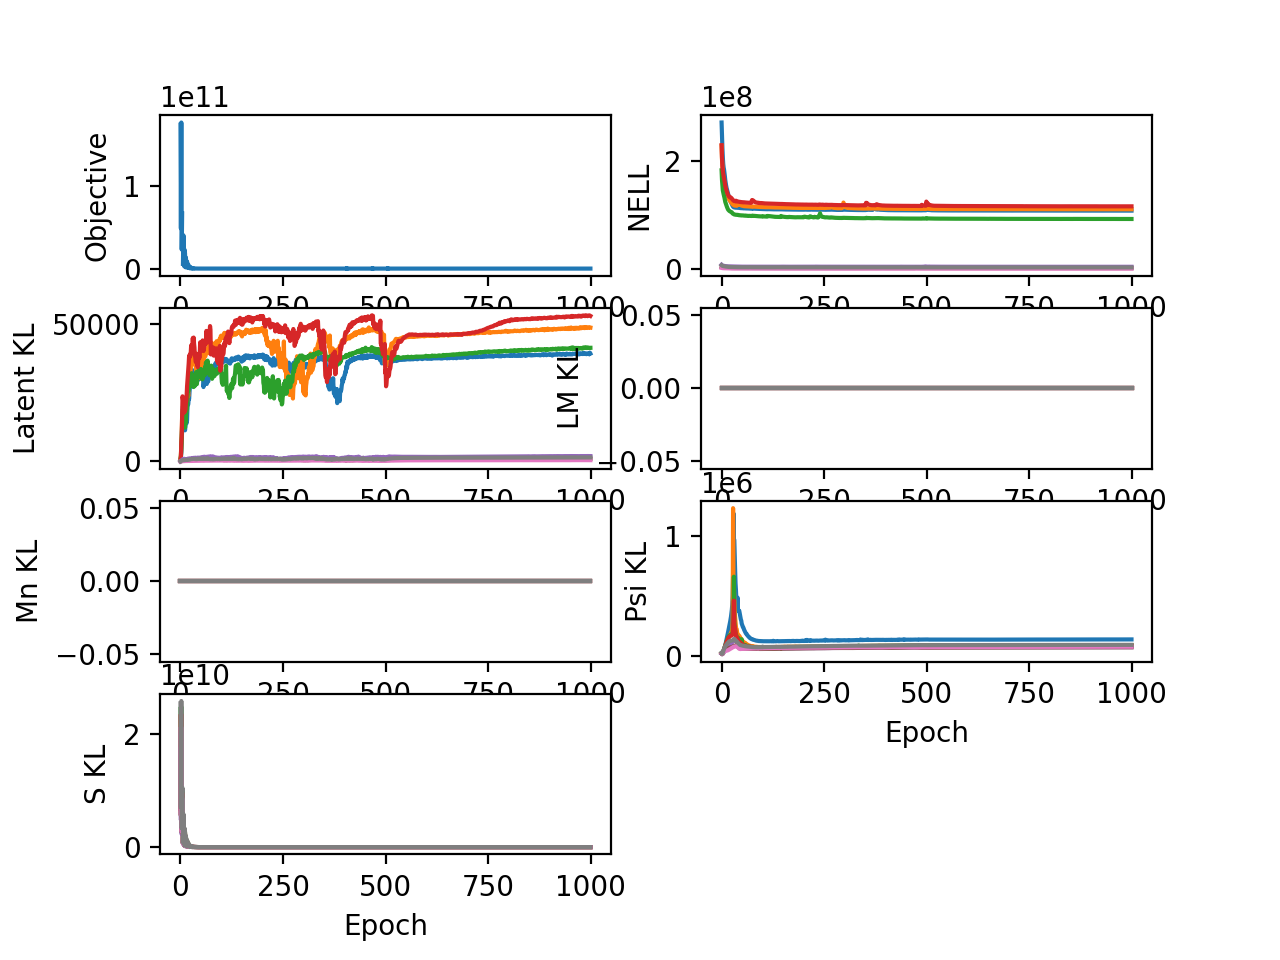

In [31]:
for log in sp_logs:
    sp_fitter.plot_log(log)

## Debug code goes here

In [32]:
post_dist = sp_vi_collections[1].posteriors.latent_post

In [33]:
cov_m = post_dist.cov().detach().numpy()

<IPython.core.display.Javascript object>


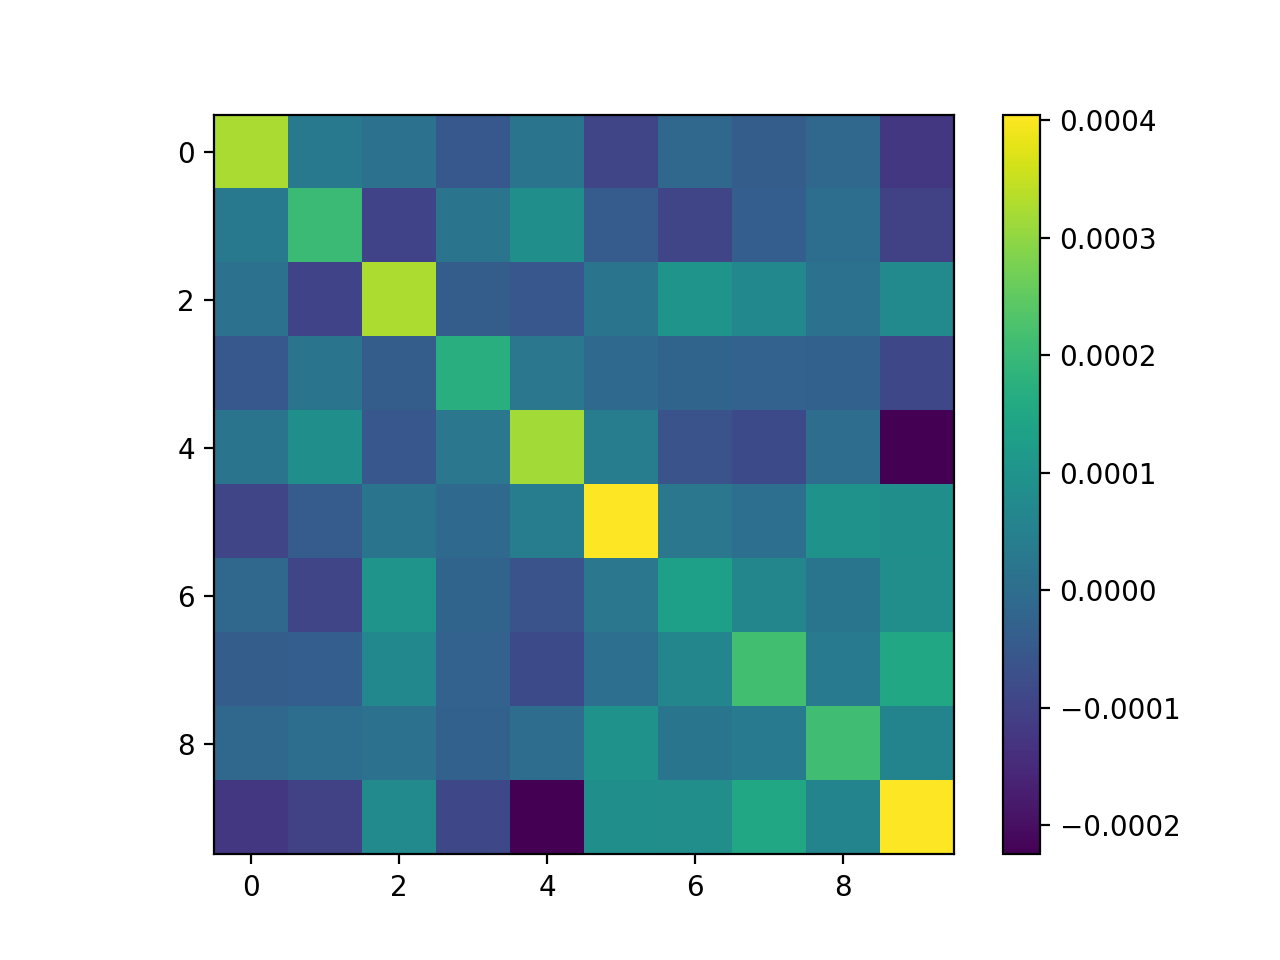

In [34]:
plt.figure()
plt.imshow(cov_m)
plt.colorbar()

In [35]:
mns = post_dist.mns.detach().numpy()

<IPython.core.display.Javascript object>


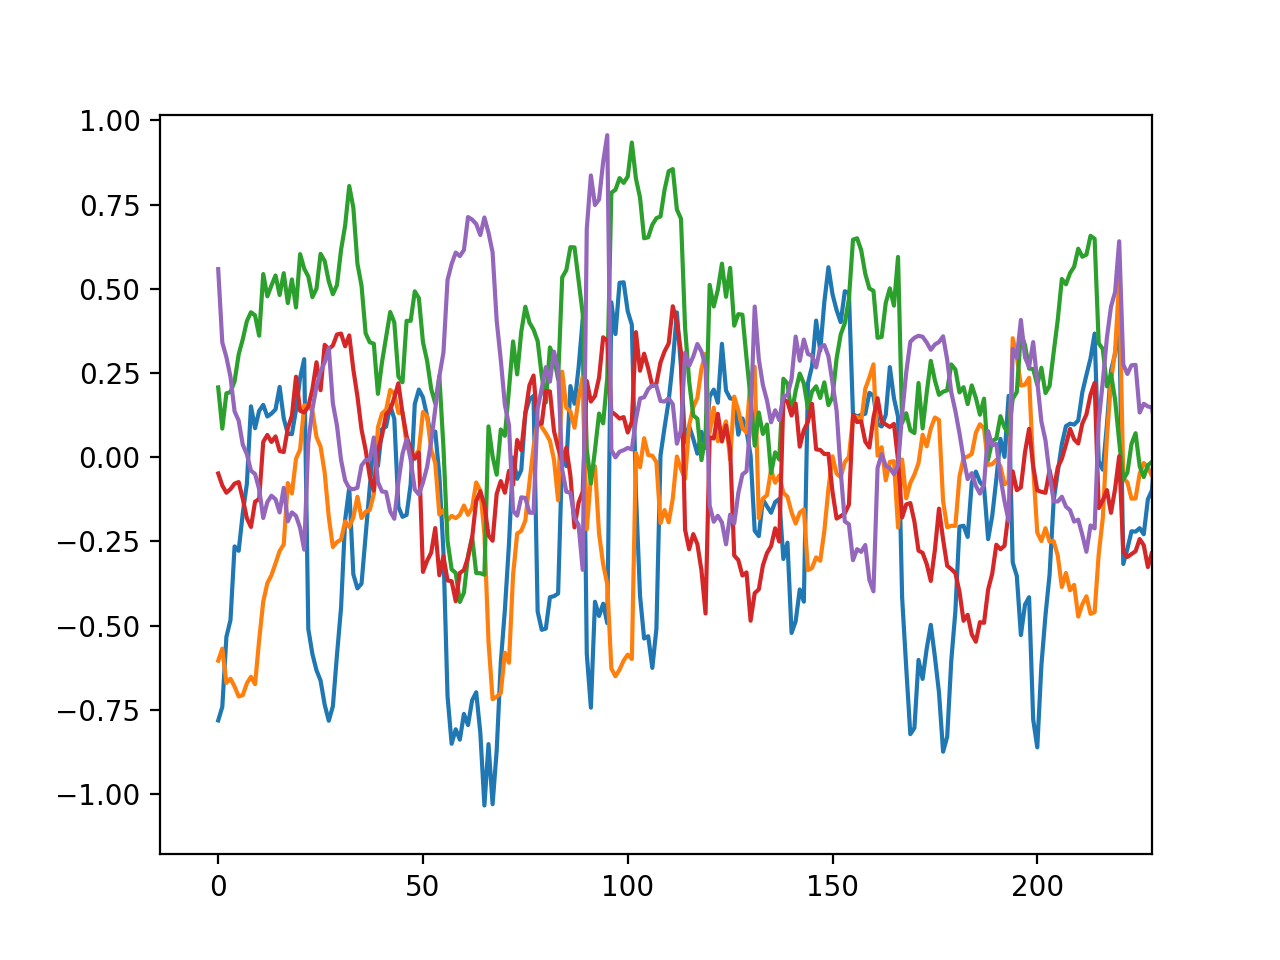

In [36]:
plt.figure()
for d_i in range(5):
    plt.plot(mns[:,d_i])